# Sentiment Analysis of RateMyProfessor data using pretrained word embeddings
## Word embedding model used: glove-wiki-gigaword-300
### Model details: Pre-trained glove vectors based on **2 Billion tweets, 27 Billion tokens, 1.2 Million vocab, uncased.**

Solution reference: https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

### Importing the required packages

In [1]:
pip install transformers,lime

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from lime import lime_text
import gensim
import gensim.downloader as gensim_api
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
import transformers
from sklearn import metrics

### Dataset Loading and Analysis

In [2]:
#Importing the data
data = pd.read_csv("/content/drive/MyDrive/Lakehead/Winter 2021/COMP 5014 Natural Language Processing/Final report/data_stripped.csv")


#Changing the student star ratings to different labels
# 4.0 - 5.0 is Good
# 2.5 - 3.5 is Average
# 1.0 - 2.0 is Bad
data['student_star'] = data['student_star'].replace([5.0],'Good')
data['student_star'] = data['student_star'].replace([4.5],'Good')
data['student_star'] = data['student_star'].replace([4.0],'Good')

data['student_star'] = data['student_star'].replace([3.5],'Average')
data['student_star'] = data['student_star'].replace([3.0],'Average')
data['student_star'] = data['student_star'].replace([2.5],'Average')

data['student_star'] = data['student_star'].replace([2.0],'Bad')
data['student_star'] = data['student_star'].replace([1.5],'Bad')
data['student_star'] = data['student_star'].replace([1.0],'Bad')

# Renaming columns
data = data.rename(columns={"student_star":"y", "comments":"text"})

# Removing blank rows
data = data.dropna()

# Snapshot of the raw data
data.sample(5)

,y,text
8805,Good,She knows her stuff and is very helpful. CS le...
10039,Good,Expects a lot of his students and is very help...
4770,Good,The course starts of hard and gets easier as t...
3553,Good,This is my favorite class I have taken ever. P...
10176,Good,No Comments


In [3]:
# Looking at the total counts for each class
data['y'].value_counts()

Good       11814
Bad         4764
Average     3415
Name: y, dtype: int64

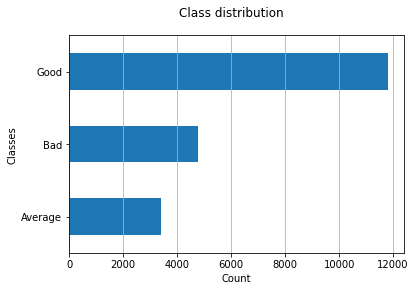

In [4]:
# Visualizing the class distribution
fig, ax = plt.subplots()
fig.suptitle("Class distribution")
data["y"].reset_index().groupby("y").count().sort_values(by = "index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
plt.ylabel("Classes")
plt.xlabel("Count")
plt.show()

### Text Processing

In [5]:
#Function to preprocess a string

def utils_preprocess_text(text, lst_stopwords=None):

    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    ps = nltk.stem.porter.PorterStemmer()
    lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [6]:
# Getting the english stopwords
nltk.download('stopwords')
nltk.download('wordnet')
lst_stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# Applying the preprocessing function on the text column of the data set. The preprocessed text is saved in a new column called text_clean
data["text_clean"] = data["text"].apply(lambda x: utils_preprocess_text(x, lst_stopwords=lst_stopwords))

In [8]:
# Snapshot of the data after cleaning
data.sample(5)

,y,text,text_clean
11274,Good,"At first, he may seem a bit confusing, but giv...",first may seem bit confus give time trueli one...
8416,Bad,The class was not useful at all. The most impo...,class use import thing professor fake respect ...
5820,Bad,"boring, uninspiring, uptight and snappy",bore uninspir uptight snappi
15497,Average,I dunno what this first guy is saying. She was...,dunno first guy say first proff actual make lo...
12809,Average,"Extremely boring, give a lot of tests and read...",extrem bore give lot test read abil talk class...


In [9]:
# Splitting the data into 70% training and 30% testing
data_train, data_test = model_selection.train_test_split(data, test_size=0.3)

# Getting the target
y_train = data_train["y"].values
y_test = data_test["y"].values

### Word Embedding Model

In [10]:
corpus = data_train["text_clean"]

# Create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

# Detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)

trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [11]:
# Loading the pre-trained Word Embedding model 

nlp = gensim_api.load("glove-wiki-gigaword-300")

In [12]:
# Checking if word is transformed into a vector
word = "bad"
nlp[word].shape

(300,)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


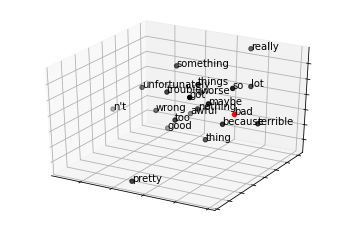

In [13]:
# Visualizing a given word and its context into a smaller dimensional space

word = "bad"
fig = plt.figure()

# Word embedding
tot_words = [word] + [tupla[0] for tupla in nlp.most_similar(word, topn=20)]
X = nlp[tot_words]

# PCS to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)

# Create dataframe
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1

# Making a 3D plot
from mpl_toolkits.mplot3d import Axes3D

ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], dtf_[dtf_["input"]==0]['y'], dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], dtf_[dtf_["input"]==1]['y'], dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], yticklabels=[], zticklabels=[])

for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

Feature engineering on training set

In [14]:
# Tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index

In [15]:
# Create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)

In [16]:
# Padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen = 40, padding="post", truncating="post")

In [17]:
# Shape of feature matrix
# Number of sequences x Sequences max length
X_train.shape

(13995, 40)

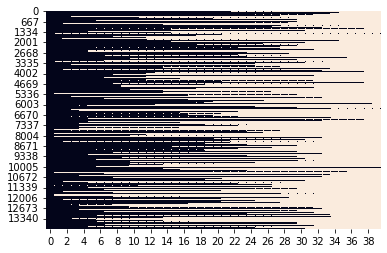

In [18]:
# Visualizing the feature matrix

sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [19]:
# Checking how a given word from the train set has been transformed into a sequence with the padding and the vocabulary

i = 0

# List of text ["I like this", ...]
len_txt = len(data_train["text_clean"].iloc[i].split())
print("from: ", data_train["text_clean"].iloc[i], "| len:", len_txt)

# Sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

# Vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", data_train["text_clean"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[data_train["text_clean"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  professor schauer passion compassion person patient beyond measur help student succeed foster place learn spit right answer schauer encourag question perfect take class profess understand cluelessawesom person class | len: 28
to:  [   4 4082  162 1926   72  661  593 3323    6   11  305 2092  433   24
 3324  243   91 4082  370   35  688    3    2 1136   37 5564   72    2
    0    0    0    0    0    0    0    0    0    0    0    0] | len: 40
check:  professor  -- idx in vocabulary --> 4
vocabulary:  {'NaN': 1, 'class': 2, 'take': 3, 'professor': 4, 'teacher': 5} ... (padding element, 0)


Feature engineering on testing set

In [20]:
corpus = data_test["text_clean"]

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])

## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=40,
             padding="post", truncating="post")

In [21]:
# Shape of feature matrix
# Number of sequences x Sequences max length
X_test.shape

(5998, 40)

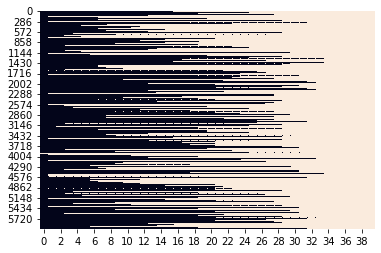

In [22]:
# Visualizing the feature matrix
sns.heatmap(X_test==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [23]:
# Creating the matirx of embedding which will be used as weight matrix
# Start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))

for word,idx in dic_vocabulary.items():
    # Update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    # if word not in model then skip and the row stays all 0s
    except:
        pass

In [24]:
# Shape of embedding matrix: Length of vocabulary extracted from the corpus x Vector size
embeddings.shape

(12410, 300)

In [25]:
word = "bad"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 95 |idx
embeddings[idx]: (300,) |vector


### Creating the neural network
Network details:


1.   Embedding layer that takes the sequences as input and the word vectors as weights
2.   Attention layer that won’t affect the predictions but it’s going to capture the weights of each instance and allow us to build a nice explainer
3.   Two layers of Bidirectional LSTM to model the order of words in a sequence in both directions.
4.   Two final dense layers that will predict the probability of each sentiment category.

In [26]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(40,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=40, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=40)

## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=40, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=40, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(3, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 300)      3723000     ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 300, 40)      0           ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 300, 40)      1640        ['permute[0][0]']                
                                                                                              

### Training

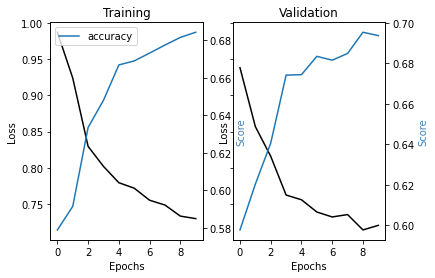

In [27]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## train
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)

## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

### Testing

In [28]:
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]

### Visualizing the results

Accuracy: 0.66
Auc: 0.76
Detail:
              precision    recall  f1-score   support

     Average       0.33      0.01      0.02      1012
         Bad       0.52      0.63      0.57      1435
        Good       0.72      0.86      0.79      3551

    accuracy                           0.66      5998
   macro avg       0.52      0.50      0.46      5998
weighted avg       0.61      0.66      0.61      5998



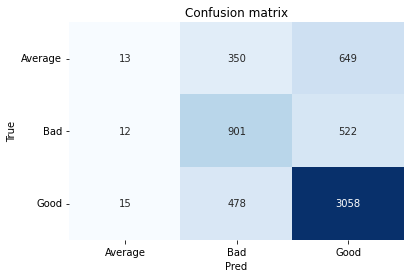

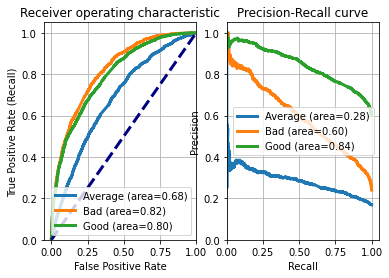

In [29]:
from sklearn import metrics

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
# Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
# Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)

# Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
# Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

### Using explainer model to explain a classification

True: Good --> Pred: Good | Prob: 0.88
Good: She is one of the most amazing teachers you could have. Sweet, caring, and genuine. She really loves what she teaches and it shows! She makes English/Literature fun and is just a pleasure to have as a teacher!


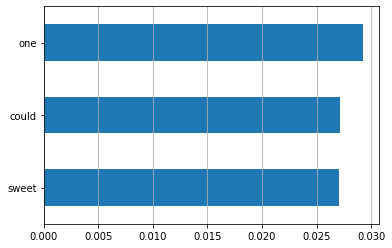


Text with highlighted words



In [34]:
# Select observation
i = 13
txt_instance = data_test["text"].iloc[i]

# Check true class and predicted class
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
print(y_test[i] + ": " + data_test["text"].iloc[i])

# Show explanation

# 1. preprocess input
lst_corpus = []
for string in [re.sub(r'[^\w\s]','', txt_instance.lower().strip())]:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
X_instance = kprocessing.sequence.pad_sequences(
              tokenizer.texts_to_sequences(corpus), maxlen=40, 
              padding="post", truncating="post")

# 2. Get attention weights
layer = [layer for layer in model.layers if "attention" in 
         layer.name][0]
func = K.function([model.input], [layer.output])
weights = func(X_instance)[0]
weights = np.mean(weights, axis=2).flatten()

# 3. Rescale weights, remove null vector, map word-weight
dic_word_weigth = {word:weights[n] for n,word in 
                   enumerate(lst_corpus[0]) if word in 
                   tokenizer.word_index.keys()}

# 4. Barplot to see contribution of word
if len(dic_word_weigth) > 0:
   dtf = pd.DataFrame.from_dict(dic_word_weigth, orient='index', 
                                columns=["score"])
   dtf.sort_values(by="score", 
           ascending=True).tail(3).plot(kind="barh", 
           legend=False).grid(axis='x')
   plt.show()
else:
   print("--- No word recognized ---")

# 5. Produce html visualization
text = []
for word in lst_corpus[0]:
    weight = dic_word_weigth.get(word)
    if weight is not None:
         text.append('<b><span style="background-color:rgba(100,149,237,' + str(weight) + ');">' + word + '</span></b>')
    else:
         text.append(word)
text = ' '.join(text)

# 6. Visualize on notebook
print("\n\033[1m"+"Text with highlighted words\n")
from IPython.core.display import display, HTML
display(HTML(text))